# 102 flowers

Le but est d'utiliser un modèle préentrainé afin d'extraire les features (qui contiennent plus d'informations que les prédictions finales) du dataset 102flowers.

### Import modules

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights',
 'RegNet_X_1_6GF_Weights',
 'R

### Importation des datas

In [2]:
transform1 = transforms.Compose([transforms.Resize(256),transforms.ToTensor(),transforms.CenterCrop(224),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
flowers=torchvision.datasets.Flowers102("data", 'train',transform1, download = True)
print(flowers)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               CenterCrop(size=(224, 224))
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


On a besoin de normaliser nos images selon les paramètres du modèle Resnet que l'on va utiliser. En effet comme il est déjà pré-entrainé, si on fait passer des images au mauvais format dans le réseau de neurones, ce dernier n'arrivera pas à effectuer les bonnes prédictions. On trouve les paramètres à utiliser dans la docu de ResNet:
 - We are defining a variable transform which is a combination of all the image transformations to be carried out on the input image.
 - Resize the image to 256×256 pixels. Peut être dangereux mais ici on part du principe que nos images sont carrées don c'est ok.
 - Crop the image to 224×224 pixels about the center.
 - Convert the image to PyTorch Tensor data type.
 - Normalize the image by setting its mean and standard deviation to the specified values.

### Load Data

In [3]:
flowers._images_folder

WindowsPath('data/flowers-102/jpg')

In [4]:
flowers[15][0]

tensor([[[-1.1075, -1.1247, -1.1760,  ..., -1.2959, -1.2103, -1.1247],
         [-1.1589, -1.1760, -1.1760,  ..., -1.2445, -1.1760, -1.0904],
         [-1.2274, -1.2274, -1.1932,  ..., -1.1932, -1.1589, -1.1075],
         ...,
         [-1.8953, -1.8610, -1.8268,  ..., -1.5870, -1.6042, -1.6042],
         [-1.9124, -1.8782, -1.7925,  ..., -1.6042, -1.6213, -1.6042],
         [-1.8439, -1.7583, -1.6042,  ..., -1.6727, -1.6555, -1.6213]],

        [[-0.7402, -0.7752, -0.8452,  ..., -1.2829, -1.0378, -0.9153],
         [-0.8277, -0.8277, -0.8277,  ..., -1.1253, -1.0028, -0.8452],
         [-0.8803, -0.8803, -0.8452,  ..., -1.0028, -0.9503, -0.8452],
         ...,
         [-1.7206, -1.6856, -1.6506,  ..., -1.2654, -1.2654, -1.2829],
         [-1.7031, -1.6155, -1.5280,  ..., -1.2829, -1.3179, -1.3004],
         [-1.6155, -1.4755, -1.3354,  ..., -1.3880, -1.3880, -1.3354]],

        [[-0.9853, -0.8807, -0.9156,  ..., -1.5081, -1.4036, -1.2816],
         [-1.0027, -0.8807, -0.8633,  ..., -1

In [5]:
dataloader=torch.utils.data.DataLoader(flowers, batch_size=4, shuffle=True, num_workers=4)
class_names=flowers._labels
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataloader)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,

On utilise ici un dataloaders pour gagner en vitesse. Le dataloader va permettre d'envoyer des batchs (des sacs de plusieurs images) au réseau de neurones au lieu de les envoyer une à une. Pour la phase de test, c'est seuleument pour une question de vitesse qu'on utilise les batchs. Pour la phase de training ils vont jouer un rôle bien plus important. En effet en envoyant des batchs on va diminuer le bruit: au lieu de se concentrer sur une seule image et tout ses détails, le réseau de neurones va traiter plusieurs images en même temps et va donc faire plus d'approximations, ce qui conduira à un traitement plus général. Les batchs permettent d'éviter l'overfitting. On a un phénomène de trade-off qui apparait. Plus on envoit d'images en même temps, plus on aura une solution générale, mais plus cela sera difficile à traiter pour la machine (c'est aussi pour cette raison qu'on ne peut pas envoyer toutes les images en une seule fois). 
On n'utilise pas ici l'option shuffle. Elle permet d'envoyer les images mélangées, ici elles sont triés par ordre croissant de label. Cette option est nécessaire lorsqu'on réalise le training car si on envoit toutes les images bien triées, on arrivera au même phénomène que lorsqu'on envoit les images une à une. Le num_workers permet de paralléliser les commandes de traitement de batchs qui peuvent être un peu long à mettre en place. On utilisera dans notre cas un CPU car nous ne travaillons pas encore avec le cluster.

### Visualize a few images

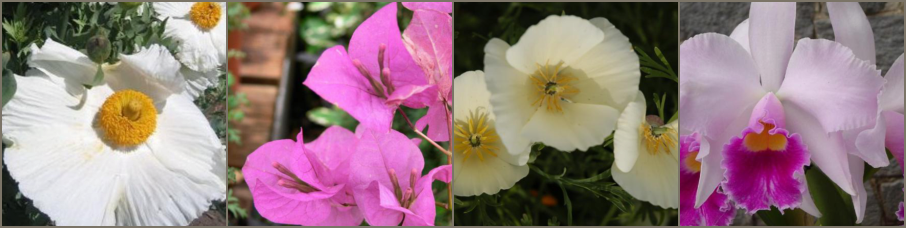

In [16]:
inputs, classes = next(iter(dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)*255
    inp= inp.astype(np.uint8)
    return inp
Image.fromarray((imshow(out)))


### Features extractor

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Identity(num_ftrs, 2)
model_conv = model_conv.to(device)

C:\Users\Bacquié\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Bacquié\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


On utilise le réseau Resnet18, pré-entrainé sur un dataset1. On souhaite le tester sur un dataset2. Pour se faire on va décider que les paramètres des n-1 premières couches ont été bien entrainé et que l'on peut les conserver: param.requires_grad=False. On va ensuite remplacer la dernière couche par l'identité afin d'avoir comme output les features.

### Visualizing the model predictions

In [8]:
def visualize_model(model,dataloader):
    L_features=[]
    model.eval()
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            L_features.append(outputs)
    return L_features
L_features=visualize_model(model_conv,dataloader)
print(L_features)

[tensor([[1.7263, 0.2127, 0.2323,  ..., 0.3358, 0.6324, 1.2407],
        [1.2907, 0.0271, 0.8342,  ..., 2.5860, 0.2531, 0.0031],
        [0.5912, 0.2258, 0.5292,  ..., 0.3682, 0.5417, 0.4827],
        [0.0368, 0.0050, 0.0602,  ..., 0.6916, 0.2358, 2.4438]]), tensor([[0.2095, 0.4949, 0.4507,  ..., 0.6891, 0.5526, 0.1304],
        [1.4741, 0.5674, 0.0582,  ..., 0.6603, 0.6843, 2.2943],
        [0.3652, 0.0408, 0.7080,  ..., 0.5239, 0.9879, 1.6536],
        [0.0608, 0.2784, 1.3207,  ..., 0.0150, 1.0992, 2.2474]]), tensor([[0.4871, 0.6044, 0.4465,  ..., 1.8132, 0.3006, 1.2054],
        [0.3161, 0.0000, 0.3751,  ..., 0.0245, 0.6104, 0.1609],
        [0.4824, 0.4603, 0.0000,  ..., 0.8557, 0.3248, 0.0877],
        [0.7037, 0.1400, 0.7136,  ..., 0.6977, 1.0783, 0.1171]]), tensor([[1.6020, 0.0264, 0.6308,  ..., 1.0273, 1.1258, 2.1688],
        [0.8531, 0.0042, 0.3207,  ..., 0.6688, 0.7057, 1.1556],
        [0.7206, 0.5653, 0.2200,  ..., 1.1969, 0.4594, 1.4153],
        [0.4645, 0.0754, 0.0869, 

torch.no_grad(): on ne garde pas en mémoire les différentes dérivées partielles qui serviraient à faire la descente de gradient car on en a pas besoin ici et qu'elles prennent énormément de place. On se met en mode eval pour désactiver tous les drop out ou autre techniques utilisées lors du training et qui doivent être enlevées pour le test afin d'avoir tous les layers bien actifs et faire de bonnes prédictions. La fonction enumerate est essentielle au bon fonctionnement du code sinon on assigne deux variables à une seule.

### Creation du vecteur feature

In [17]:
L_features[0].shape  # 4images par 4 images, 512 features

torch.Size([4, 512])

In [18]:
features=torch.vstack(L_features)
torch.vstack(L_features).shape #1020 features

torch.Size([1020, 512])

In [19]:
np.array(flowers._labels).shape

(1020,)

### Graphique des features en fonction des classes 

In [10]:
import sklearn 
features=torch.vstack(L_features) 
targets=np.array(flowers._labels)  #classe de la fleur 
features = features.detach().cpu().numpy()

from sklearn.manifold import TSNE
cmap = plt.get_cmap("hsv")
colors = list(map(lambda x: x[:3], map(cmap, [i / 50 for i in range(50)])))

plottable_data = TSNE(2).fit_transform(features) #projeter dans un espace de dimension 2 en gardant le mieux possible les distances


C:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


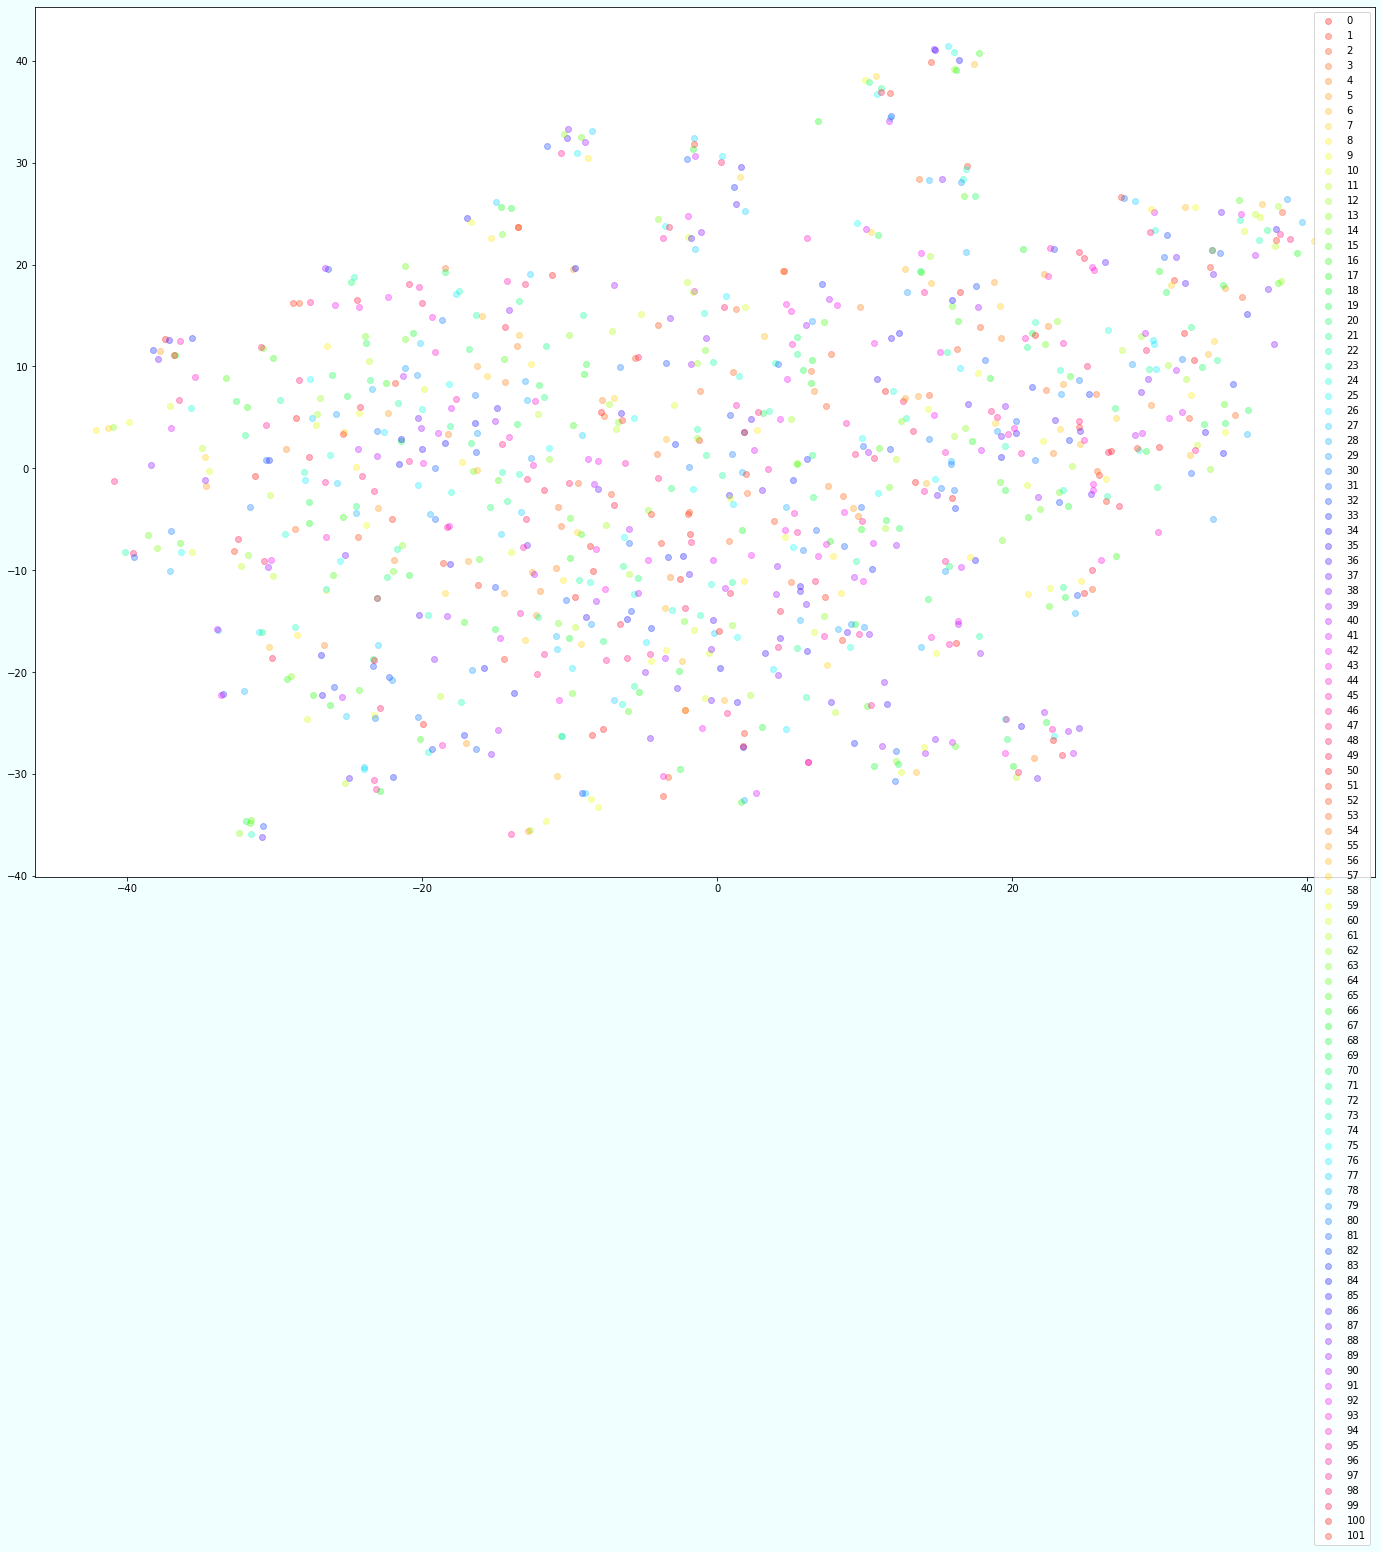

In [11]:
plt.figure(figsize=(24, 16), facecolor="azure")
for i, label in enumerate(np.unique(targets)):
    tmp = plottable_data[(targets==label)]
    plt.scatter(tmp[:,0], tmp[:, 1], label=label, alpha=0.3, color=colors[i % len(colors)])

plt.legend()
#plt.savefig("tests/manual/50_random_visualisation.png")
plt.show()